# Статистика, DS-поток
## Практическое задание 1. Методы интегрирования

In [23]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

%matplotlib inline

---
## Задача 1.

Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функции. Реализация должна уметь вычислять интеграл вида:
$$ \int\limits_{l_1}^{h_1} ... \int\limits_{l_d}^{h_d} f(x_1, ... , x_d) dx_1 ... dx_d $$

*Детали реализации*: на вход функции подаются векторы $l = (l_1, ... , l_d)$ и $h = (h_1, ... ,h_d)$, число $n$ -- максимальное допустимое число вызовов функции $f$ (если вы не делаете лишних вызовов, оно равно числу точек-центров отрезков, прямоугольников, параллелипипедов, и т.д. в многомерных случаях). Использование циклов, кроме циклов по числу интегралов $d$, **наказуемо**.

Для быстрой работы метода прямоугольников мы будем использовать функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. Как всегда, настоятельно советуем читать документацию.

In [24]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]

# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1

# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [25]:
class Integrator:
    
    @staticmethod
    def integrate(f, low, high, n, method="rectangle"):
        """
        Вычисление определенного интеграла.
        
        Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
        n --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").
                            
        Возвращает приближенное значение интеграла.
        """
        
        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        n = int(n)

        return Integrator.methods[method](f, low, high, n)
    
    
    def integrate_monte_carlo(f, low, high, n):
        """Метод монте-карло"""
        
        dim = len(high)
        dots = sps.uniform.rvs(size=(n, dim), loc=low, scale=high-low) # случайные точки, в которых будем вычислять функцию
#         diff =  # длины отрезков разбиения (P.S в моей реализации не нужно)
        # вычисление интеграла
        f_vect = np.vectorize(f, signature='(m)->()')
        return f_vect(dots).mean()

    
    def integrate_rectangle(f, low, high, n):
        """Метод прямоугольников"""
        
        dim = len(high)
        
        n_rounded = int(n ** (1 / dim)) + 1 # количество точек, в которых вычисляем функцию
        diff = (high - low) / (n_rounded - 1) # длины отрезов разбиения
        centers_of_ranges = np.zeros((dim, n_rounded))
        
        # для каждой размерности найдите центры отрезков разбиения 
        intervals = np.linspace(low, high, n_rounded)
        centers_of_ranges = (intervals[:-1] + np.diff(intervals, axis=0) / 2).T

        centers = np.meshgrid(*centers_of_ranges)
        f = np.vectorize(f, signature='(m)->()')
        f_vals = f(np.stack(centers).reshape(dim, -1).T) 
        return f_vals.sum() * np.prod(diff)

    methods = {
        "rectangle": integrate_rectangle,
        "monte_carlo": integrate_monte_carlo
    }

Вычислите $\int\limits_0^1 \int\limits_3^4 \left(x^2 + y^2\right) dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов? Объясните результаты с точки зрения теории.

In [26]:
square_sum = lambda x: np.sum(x**2, axis=0)

low = [0, 3]
high = [1, 4]
n = 10**6

In [27]:
from scipy import integrate
f =  lambda y, x: x**2 + y**2
real_val = integrate.dblquad(f, 0, 1, 3, 4)[0]
print(real_val)

12.666666666666666


In [28]:
%%time

monte_carlo = Integrator.integrate(square_sum, low, high, n, 'monte_carlo')
print('Значение интеграла методом Монте-Карло: ', monte_carlo)
diff_monte = abs(monte_carlo - real_val)
print('Разница с истинным значением: ', diff_monte)

Значение интеграла методом Монте-Карло:  12.66472333928797
Разница с истинным значением:  0.001943327378695514
CPU times: user 8.48 s, sys: 86.4 ms, total: 8.57 s
Wall time: 8.68 s


In [29]:
%%time

rectangle = Integrator.integrate(square_sum, low, high, n, 'rectangle')
print('Значение интеграла методом прямоугольников: ', rectangle)
diff_rect = abs(rectangle - real_val)
print('Разница с истинным значением: ', diff_rect)

Значение интеграла методом прямоугольников:  12.6666665
Разница с истинным значением:  1.6666666624587378e-07
CPU times: user 8.13 s, sys: 43 ms, total: 8.18 s
Wall time: 8.22 s


In [30]:
diff_monte / diff_rect

11659.964301611664

**Вывод:** *В моей реализации методы работают за схожее время, метод прямоугольников - немного быстрее. Также ошибка (разница с истинным значением интеграла) у метода прямоугольников сильно ниже монте-карло. Это подтверждается математически: в данном случае (n-большое, применима ЦПТ) у Монте-Карло погрешность малости $\frac{1}{\sqrt{n}}$, у прямоугольников - $\frac{1}{{n^2}}$, то есть ниже*

---
## Задача 2.

Для $d = 1...8$ оцените скорость сходимости методов для интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i$$

Т.е. $\int\limits_0^1 x_1^2 dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right) dx_1 dx_2$ и так далее.

Вычислите точное значение этого интеграла и для каждого $d$ постройте график зависимости вычисленного значения интеграла от числа $n$ вызовов подынтегральной функции (в корректном решении равно числу точек-центров), которое разрешено использовать для каждого метода вычисления интеграла. Рекомендуется рассмотреть значения $n$ вплоть до $d \times 1000$.

Для вашего удобства, мы написали функцию, которая строит графики в этой задаче.

In [31]:
max_dim = 8


def plot_convergence(f, low, high, n_list, theoretical_value, max_dim):
    """
    Построение графиков сходимости методов Монте-Карло и прямоугольников.
    
    Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования.
            Передаются в том же порядке, в котором функция 
            принимает аргументы).
    n_list --- список.
    theoretical_value --- точное значение интеграла.
    max_dim --- максимальная кратность интеграла.
    """
    
    source = np.arange(max_dim) + 1
    i = Integrator()
    
    for d in source:
        rectangles_computed = np.zeros(len(n_list))
        monte_carlo_computed = np.zeros(len(n_list))
        
        for n in np.arange(len(n_list)):
            mn = i.integrate(f, low[:d], high[:d], n_list[n],
                             method="monte_carlo")
            rc = i.integrate(f, low[:d], high[:d], n_list[n])
            monte_carlo_computed[n] = mn
            rectangles_computed[n] = rc
        plt.figure(figsize=(15, 5))
        plt.title('Зависимость вычисленного значения интеграла' +
                  ' от n для d = {}'.format(d), fontsize=14)      
        plt.xlabel("Число вызовов функции", fontsize=14)
        plt.ylabel("Значение интеграла", fontsize=14)
        plt.plot(n_list, monte_carlo_computed, color='blue',
                 label="по методу Монте-Карло")
        plt.plot(n_list, rectangles_computed, color='magenta',
                 label="по методу прямоугольников")
        plt.axhline(y=theoretical_value[d - 1], color='indigo',
                    linestyle='--', label="истинное значение")
        plt.legend(fontsize=14)

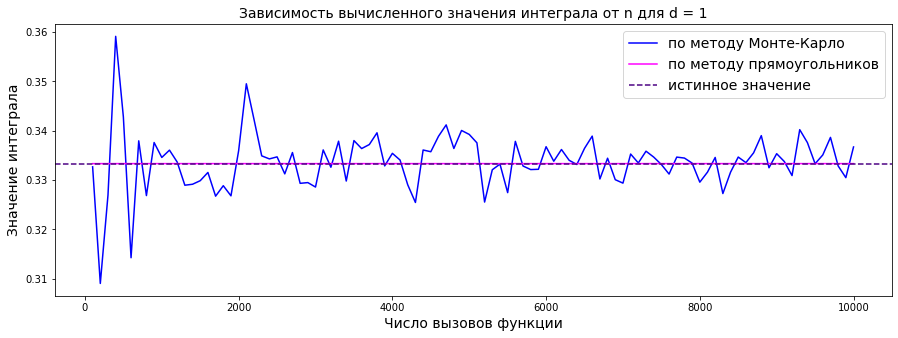

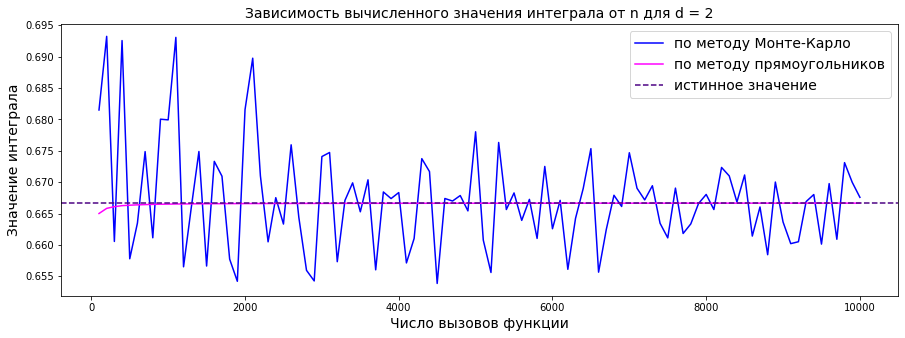

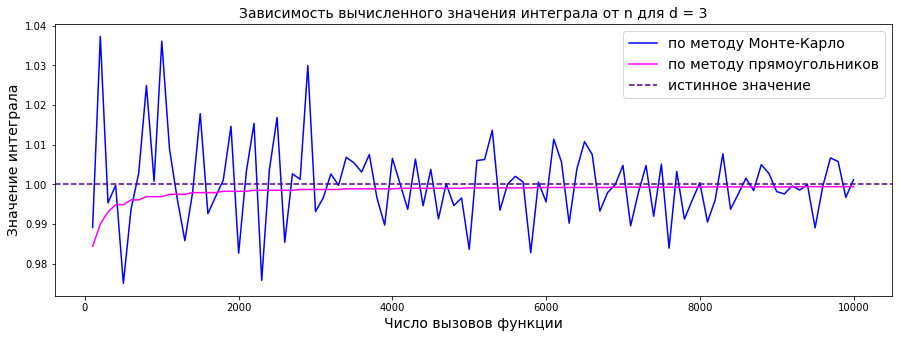

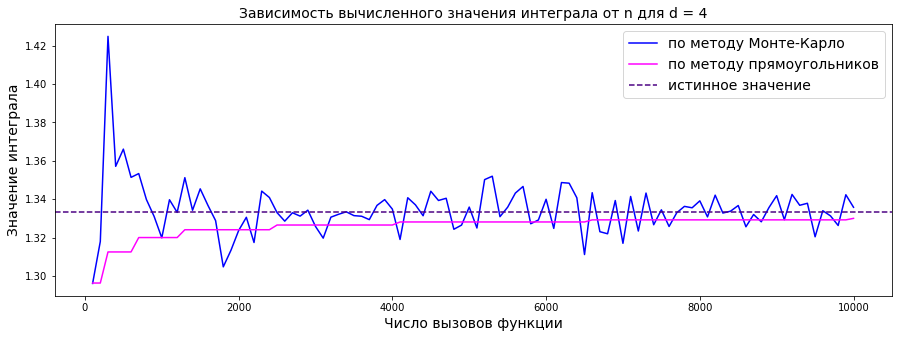

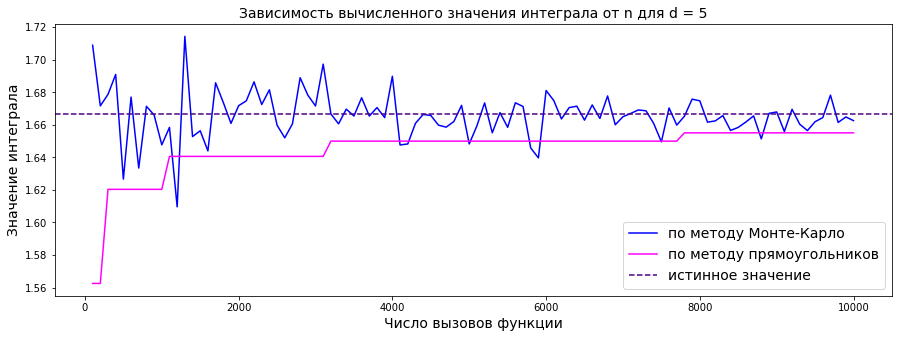

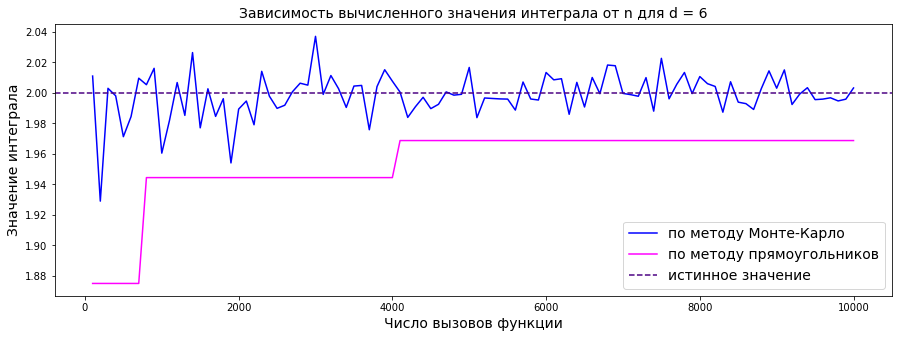

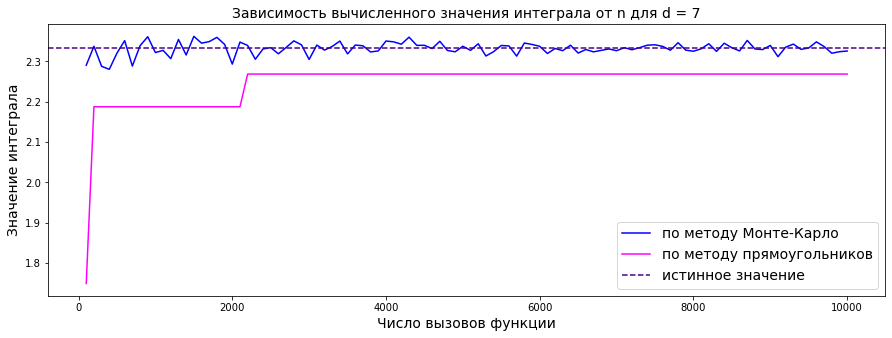

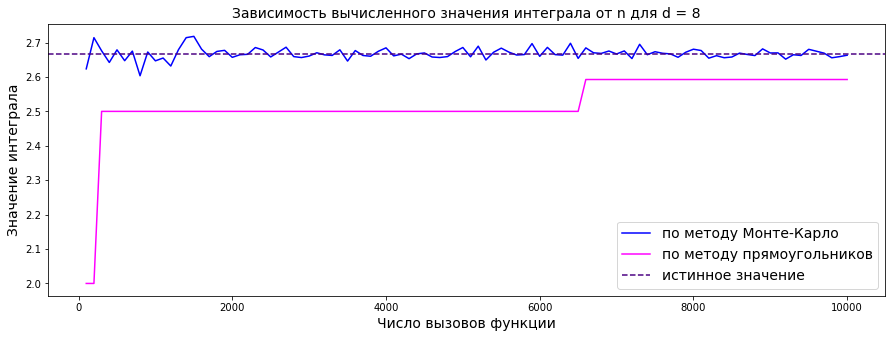

In [32]:
high = [1] * max_dim
low = [0] * max_dim
n_list = np.array(np.arange(100, 10001, 100))
theoretical_values = [i/3 for i in range(1, max_dim + 1)]

plot_convergence(square_sum, low, high, n_list, theoretical_values, max_dim)

Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод.

*При d <= 5 быстрее сходится метод прямоугольников, при d > 5 быстрее сходится метод монте-карло. Поэтому можно сделать вывод, что монте-карло стоит использовать для интегралов высокой кратности, повысив количество точек вычисления функции, а для низкой - прямоугольники.*

С чем связано такое поведение графиков?

*Оценка в методе монте-карло вероятностная, поэтому у значений большой разброс при малых количествах вызовов (n), и только при больших n (по ЦПТ, показывали на семинаре) погрешность будет иметь порядок малости $\frac{1}{\sqrt{n}}$. В методе прямоугольников оценки образуют длинные плато, а при больших d значение интеграла меняется почти скачкообразно, так как отклонение оценки от истинного меняется слабо. Ухудшение сходимости с ростом d связано с тем, что для формирования плотной сетки разбиения нужно больше точек, и значит еще больше вызовов функции*

Сравните результаты с предыдущей задачей.

*В предыдущей задаче получили, что при крастности интеграла 2 метод прямоугольников лучше приблизил истинный результат. Результаты 2ой задачи это подтвердили - при малой кратности точнее прямоугольники, при большой - монте-карло*

**Вывод:** *Для вычисления интегралов малой кратности стоит использовать метод прямоугльников, так как он точнее, но при повышении размерности метод Монте-Карло становится точнее.*

---
## Задача 3.

Вам предлагается численно посчитать многомерный интеграл Пуассона для размерности $d=5$ и некоторой симметричной положительно определенной матрицы $A$, которую вы выберете сами. Зависит ли интеграл от выбора $A$? 
$$\int\limits_{\mathbb{R}^d} exp( - x^T A x) dx $$

Сравните результаты двух методов с истинным значением интеграла. Как вы думаете, какой метод выдает более точный результат? Количество итераций каждого метода должно быть не менее $10^6$. Теоретическое вычисление интеграла можно не приводить, достаточно написать ответ.

In [33]:
d = 5
A = np.eye(d)

*Можно показать, что значение данного интеграла всегда равно:*

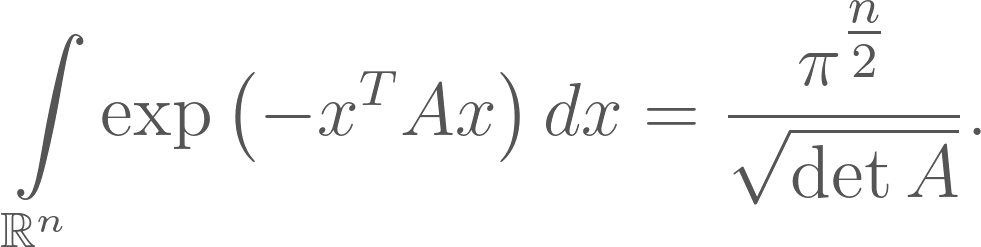

*В нашем случае (d=5, A - единичная матрица 5x5 c detA = 1) значение интграла:*

In [34]:
answ = np.pi ** (5 / 2)
answ

17.493418327624862

**Комментарий:** В этой задаче особенно важно выбрать правильные пределы интегрирования. 
Например, для единичной матрицы достаточно взять интеграл с пределами внутри области $[-5, 5]^5$

В связи с этим просим Вас ответить на наводящие вопросы. 
1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло? 
2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?

1. Так как Монте-карло опирается на случайное распределение в диапазоне пределов, слишком большие (или бесконечные) пределы приведут к тому, что «важная» часть функции, дающая основной вклад в значение интеграла может охватывать небольшой диапазон, в то время как остальное значительное количество точек почти не будет давать никакой вклад. Значит, что при стремлении пределов к бесконечности значение интеграла будет стремиться к 0. Следовательно, чтобы получить точную оценку стандартным методом Монте-Карло, потребуется невероятно большое количество точек.
2. Метод прямоугольников опирается на пределы для подсчета размеров отрезков. Чем больше область интегрирования, тем крупнее будет сетка при заданном количестве точек, в которых вычисляется функция, а значит значение интграла будет расти и стремиться к бесконечности при бесконечных пределах.

В этой задаче нельзя использовать циклы. Для вычисления функции в точках используете простые векторно-матричные операции в `numpy`.

In [35]:
def func(x):
    return np.exp(-x.T.dot(A).dot(x))

In [36]:
grid = np.array(np.meshgrid(np.arange(-5, -50, -10), np.arange(5, 50, 10)))
grid

array([[[ -5, -15, -25, -35, -45],
        [ -5, -15, -25, -35, -45],
        [ -5, -15, -25, -35, -45],
        [ -5, -15, -25, -35, -45],
        [ -5, -15, -25, -35, -45]],

       [[  5,   5,   5,   5,   5],
        [ 15,  15,  15,  15,  15],
        [ 25,  25,  25,  25,  25],
        [ 35,  35,  35,  35,  35],
        [ 45,  45,  45,  45,  45]]])

In [37]:
n = 10**6
grid[0] = grid[0].T

In [38]:
def integr_(lims, method):
    low = lims[0]
    high = lims[1]
    res = Integrator.integrate(func, low, high, n, method)
    print('Пределы: ({}, {})'.format(low[0], high[1]))
    print('Значение методом {}: '.format(method), res)
    print('Отклонение от реального значения: ', abs(res - answ))
    return res

In [39]:
list(map(lambda x: integr_(x, 'monte_carlo'), zip(grid[0], grid[1])))

Пределы: (-5, 5)
Значение методом monte_carlo:  0.00017842490777987053
Отклонение от реального значения:  17.493239902717082
Пределы: (-15, 15)
Значение методом monte_carlo:  5.223129987292632e-07
Отклонение от реального значения:  17.493417805311864
Пределы: (-25, 25)
Значение методом monte_carlo:  9.378870295554898e-10
Отклонение от реального значения:  17.493418326686974
Пределы: (-35, 35)
Значение методом monte_carlo:  4.1394536731429294e-08
Отклонение от реального значения:  17.493418286230327
Пределы: (-45, 45)
Значение методом monte_carlo:  2.026517893789239e-12
Отклонение от реального значения:  17.493418327622837


[0.00017842490777987053,
 5.223129987292632e-07,
 9.378870295554898e-10,
 4.1394536731429294e-08,
 2.026517893789239e-12]

In [40]:
list(map(lambda x: integr_(x, 'rectangle'), zip(grid[0], grid[1])))

Пределы: (-5, 5)
Значение методом rectangle:  17.493418367284338
Отклонение от реального значения:  3.965947570350181e-08
Пределы: (-15, 15)
Значение методом rectangle:  38.30645757730612
Отклонение от реального значения:  20.813039249681257
Пределы: (-25, 25)
Значение методом rectangle:  411.5841408724447
Отклонение от реального значения:  394.09072254481987
Пределы: (-35, 35)
Значение методом rectangle:  2213.2674974221277
Отклонение от реального значения:  2195.7740790945027
Пределы: (-45, 45)
Значение методом rectangle:  7776.000000000017
Отклонение от реального значения:  7758.506581672393


[17.493418367284338,
 38.30645757730612,
 411.5841408724447,
 2213.2674974221277,
 7776.000000000017]

**Вывод**: *Теоретические предположения подтвердились: в методе Монте-Карло с увеличением пределов интегрирования значение интеграла близится к 0. Замечу так же, что метод Монте-Карло в данном случае дает очень плохую оценку даже на малом промежутке. В методе прямоугольников с увеличением пределов интегрирования значение интеграла близится растет. При небольшом промежутке интегрирования оценка достаточно точная.*

Рассмотрим отношение интегралов: 
$$
F(t) = \frac{ \int\limits_{-\infty}^{t_1} ... \int\limits_{-\infty}^{t_k} exp \left( - \frac12 x^T A x \right) dx}{ \int\limits_{\mathbb{R}^n} exp \left( - \frac12 x^T A x \right) dx}.
$$
В чем его вероятностный смысл?

*Знаменатель - это условие нормировки, а вся функция - функция распределения многомерного нормального распределения*